In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send, interrupt, Command
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3
from openai import OpenAI
from typing import TypedDict, Annotated
import operator
import subprocess
import textwrap
import base64

class State(TypedDict):
    video_file: str
    audio_file: str
    transcription: str
    final_summary: str
    summaries: Annotated[list[str], operator.add]
    thumbnail_prompts: Annotated[list[str], operator.add]
    thumbnail_sketches: Annotated[list[str], operator.add]
    user_feedback: str
    choisen_prompt: str

In [2]:
def extract_audio(state: State):
    output_file = state["video_file"].replace("mp4", "mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0",
        "-y",
        output_file,
    ]

    subprocess.run(command)
    return {"audio_file": output_file}


def transcribe_audio(state: State):
    # audio_file = state["audio_file"]
    client = OpenAI()
    with open(state["audio_file"], mode="rb") as audio_file:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=audio_file,
            language="ko",
            prompt="Netherlands, Rotterdam, Amsterdam, The Hage",
        )
    return {
        "transcription": transcription,
    }


def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({"id": i + 1, "chunk": chunk})

    return [Send("summarize_chunk", chunk) for chunk in chunks]


def summarize_chunk(chunk):

    llm = init_chat_model("openai:gpt-4o-mini")
    summary = []

    chunk_id = chunk["id"]
    chunk = chunk["chunk"]

    prompt = f"""
    다음 청크를 요약해주세요.
    청크: {chunk}
    """
    response = llm.invoke(prompt)

    summary = f"[chunk {chunk_id}] {response.content}"
    return {
        "summaries": [summary],
    }


def mega_summary(state: State):
    summary = state["summaries"]

    prompt = f"""
    다음 요약본은 영상 스크립트를 여러 청크로 나누고 각 청크를 요약한 것입니다.

    요약본을 모든 키워드를 아우를 수 있는 최종 요약본으로 만들어주세요.

    요약본: {summary}
    """
    llm = init_chat_model("openai:gpt-4o-mini")

    response = llm.invoke(prompt)

    return {
        "final_summary": response.content,
    }


def dispatch_artists(state: State):
    final_summary = state["final_summary"]
    return [
        Send("generate_thumbnails", arg={"id": i, "summary": final_summary})
        for i in [1, 2, 3, 4]
    ]


def generate_thumbnails(args):

    id = args["id"]
    summary = args["summary"]

    prompt = f"""
    Based on this video summary, create a detailed visual prompt for a YouTube thumbnail.

    Create a detailed prompt for generating a thumbnail image that would attract viewers. Include:
        - Main visual elements
        - Color scheme
        - Text overlay suggestions
        - Overall composition

    summary: {summary}
    """

    llm = init_chat_model("openai:gpt-4o-mini")

    response = llm.invoke(prompt)  # 유튜브 프롬프트

    client = OpenAI()

    result = client.images.generate(
        prompt=response.content,
        model="gpt-image-1",
        quality="low",
        moderation="low",
        size="auto",
    )

    image = base64.b64decode(result.data[0].b64_json)

    file_path = f"thumbnail_{id}.jpg"

    with open(file_path, "wb") as file:
        file.write(image)

    return {
        "thumbnail_prompts": [response.content],
        "thumbnail_sketches": [file_path],
    }


def human_feedback(state: State):
    feedback = interrupt(
        {
            "feedback": "가장 마음에 드는 사진을 고르고 피드백을 남겨주세요.",
            "choice": "가장 마음에 드는 사진이 몇번인가요?",
        }
    )

    user_feedback = feedback["user_feedback"]
    choisen_prompt = feedback["choisen_prompt"]

    return {
        "user_feedback": user_feedback,
        "choisen_prompt": state["thumbnail_prompts"][choisen_prompt-1],
    }


def generate_hd_thumbnail(state: State):
    user_feedback = state["user_feedback"]
    choisen_prompt = state["choisen_prompt"]

    prompt = f"""
        You are a professional YouTube thumbnail designer. Take this original thumbnail prompt and create an enhanced version that incorporates the user's specific feedback.

    ORIGINAL PROMPT:
    {choisen_prompt}

    USER FEEDBACK TO INCORPORATE:
    {user_feedback}

    Create an enhanced prompt that:
        1. Maintains the core concept from the original prompt
        2. Specifically addresses and implements the user's feedback requests
        3. Adds professional YouTube thumbnail specifications:
            - High contrast and bold visual elements
            - Clear focal points that draw the eye
            - Professional lighting and composition
            - Optimal text placement and readability with generous padding from edges
            - Colors that pop and grab attention
            - Elements that work well at small thumbnail sizes
            - IMPORTAN1: Always ensure adequate white space/padding between any text and the image borders
            - IMPORTANT2: Don't use texture expressions, thumbnails should be clean.
    """

    llm = init_chat_model("openai:gpt-4o")

    final_prompt = llm.invoke(prompt)

    client = OpenAI()

    result = client.images.generate(
        prompt=final_prompt.content,
        model='gpt-image-1',
        quality='high',
        moderation='low',
        size='auto'
    )

    image = base64.b64decode(result.data[0].b64_json)

    with open("final_thumbnail.jpg", "wb") as file:
        file.write(image)

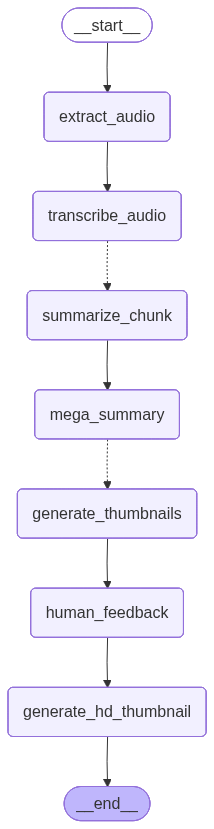

In [3]:
graph_builder = StateGraph(State)

graph_builder.add_node("extract_audio", extract_audio)
graph_builder.add_node("transcribe_audio", transcribe_audio)
graph_builder.add_node("summarize_chunk", summarize_chunk)
graph_builder.add_node("mega_summary", mega_summary)
graph_builder.add_node("generate_thumbnails", generate_thumbnails)
graph_builder.add_node("human_feedback", human_feedback)
graph_builder.add_node("generate_hd_thumbnail", generate_hd_thumbnail)

graph_builder.add_edge(START, "extract_audio")
graph_builder.add_edge("extract_audio", "transcribe_audio")
graph_builder.add_conditional_edges(
    "transcribe_audio", dispatch_summarizers, ["summarize_chunk"]
)
graph_builder.add_edge("summarize_chunk", "mega_summary")
graph_builder.add_conditional_edges(
    "mega_summary", dispatch_artists, ["generate_thumbnails"]
)
graph_builder.add_edge("generate_thumbnails", "human_feedback")
graph_builder.add_edge("human_feedback", "generate_hd_thumbnail")
graph_builder.add_edge("generate_hd_thumbnail", END)

graph = graph_builder.compile(checkpointer=InMemorySaver())
graph

In [4]:
config = {
    "configurable": {
        "thread_id": 1
    },
}

In [5]:
graph.invoke(
    {
        "video_file": "./video.mp4"
    },
    config=config
)

{'video_file': './video.mp4',
 'audio_file': './video.mp3',
 'transcription': '자소서가 언덕듣기에는 쓰기 쉬울 것 같아요 근데 여러분도 써보셔서 아시겠지만 가장 어려운 부분이 또 자소서이지 않나 자소서 쓸 때 하지 말아야 될 것부터 짚고 넘어가면 좋을 것 같아요 지금 보실 때 진짜 하지 말아야 되는 거 탈락하는 자소서는 뭐가 있을까요? 빠밤 빠밤 제가 계속 따라해야 되나요? 저희 시니어 면접위원분들께서 하시는 말씀 있는데 나는 딱 보면 알아 나름 말씀 많이 하세요 너무하신 거 아니에요? 맞습니다 그래서 그 직감에 의한 평가는 하지 않도록 저희가 계속 컨트롤을 하는 거고요 그래서 면접위원도 교육을 하는 건데요 그런데 자기소개서는 정말 딱 보면 알 수 있는 방법이 있어요 이건 직감이 아니고요 여러분들이 쓰신 자기소개서의 구조를 보면 딱 알 수 있어요 어떤 분들은 기승 경별로 막 앞쪽에서 막 이야기를 하세요 스토리텔링 하시다가 맨 마지막에 하고 싶은 말 이렇게 쓰시는데 그렇게 쓰시면 안 돼요 여러분 항상 앞에 성과, 결과부터 쓰시고 그다음에 그 성과 결과를 만들어낸 나의 액션, 상황 이런 것들을 쓰시는 거예요 시간이 없어 혹은 분량이 너무 쏟아져 라고 하면 성과만 쓰셔도 돼요 성과 플러스 나의 액션만 쓰셔도 돼요 음 성과 플러스 액션만 써야 돼요 다른 거는 안 쓰셔도 돼요 그거는 면접 때 여러분들에게 어차피 여쭤볼 거예요 그러니까 성과, 나의 액션 이런 생각을 해주셔야 되고요 두 번째 여러분들 너무 안타까운 게 있어요 내가 너무 잘났다라는 것을 보여주고 싶고 내가 이렇게 어려운 것을 했어라 하는 것을 보여주고 싶으신 건 알겠는데 이게 과연 지원하시는 회사의 직무와 어떤 연관성이 있는지를 꼭 확인을 하셔야 돼요 그것을 어필을 하셔야 돼요 그런 부분으로 해서 내가 원하는, 나의 달란 모습이 아니라 회사에서 나를 뽑고 싶어 하는지 그거를 타깃으로 해서 글을 쓰신다고 한다면 분명히 매력적인 자기소개서를 쓰실 수

In [6]:
graph.invoke(
    Command(
        resume={
        "user_feedback": "별 다른 피드백이 없어",
        "choisen_prompt": 4,
        }
    ),
    config=config,
)

{'video_file': './video.mp4',
 'audio_file': './video.mp3',
 'transcription': '자소서가 언덕듣기에는 쓰기 쉬울 것 같아요 근데 여러분도 써보셔서 아시겠지만 가장 어려운 부분이 또 자소서이지 않나 자소서 쓸 때 하지 말아야 될 것부터 짚고 넘어가면 좋을 것 같아요 지금 보실 때 진짜 하지 말아야 되는 거 탈락하는 자소서는 뭐가 있을까요? 빠밤 빠밤 제가 계속 따라해야 되나요? 저희 시니어 면접위원분들께서 하시는 말씀 있는데 나는 딱 보면 알아 나름 말씀 많이 하세요 너무하신 거 아니에요? 맞습니다 그래서 그 직감에 의한 평가는 하지 않도록 저희가 계속 컨트롤을 하는 거고요 그래서 면접위원도 교육을 하는 건데요 그런데 자기소개서는 정말 딱 보면 알 수 있는 방법이 있어요 이건 직감이 아니고요 여러분들이 쓰신 자기소개서의 구조를 보면 딱 알 수 있어요 어떤 분들은 기승 경별로 막 앞쪽에서 막 이야기를 하세요 스토리텔링 하시다가 맨 마지막에 하고 싶은 말 이렇게 쓰시는데 그렇게 쓰시면 안 돼요 여러분 항상 앞에 성과, 결과부터 쓰시고 그다음에 그 성과 결과를 만들어낸 나의 액션, 상황 이런 것들을 쓰시는 거예요 시간이 없어 혹은 분량이 너무 쏟아져 라고 하면 성과만 쓰셔도 돼요 성과 플러스 나의 액션만 쓰셔도 돼요 음 성과 플러스 액션만 써야 돼요 다른 거는 안 쓰셔도 돼요 그거는 면접 때 여러분들에게 어차피 여쭤볼 거예요 그러니까 성과, 나의 액션 이런 생각을 해주셔야 되고요 두 번째 여러분들 너무 안타까운 게 있어요 내가 너무 잘났다라는 것을 보여주고 싶고 내가 이렇게 어려운 것을 했어라 하는 것을 보여주고 싶으신 건 알겠는데 이게 과연 지원하시는 회사의 직무와 어떤 연관성이 있는지를 꼭 확인을 하셔야 돼요 그것을 어필을 하셔야 돼요 그런 부분으로 해서 내가 원하는, 나의 달란 모습이 아니라 회사에서 나를 뽑고 싶어 하는지 그거를 타깃으로 해서 글을 쓰신다고 한다면 분명히 매력적인 자기소개서를 쓰실 수